# Phase 4 Project Submission¶
- Student name: Lucas Wilkerson
- Student pace: Flex/part time
- Scheduled project review date/time:
- Instructor name: Morgan Jones

# Pneumonia Detection and Classification

## Project Overview

For this project, the aim is to build a model for image classification that can classify whether a patient has pneumonia when provided a chest x-ray image. 

## Business Problem and Stakeholder

A healthcare physician group is looking to improve their patient outcomes, specifically patients who are being diagnosed with pneumonia. Pneumonia is a significant health concern among patients, especially geriatric and pediatric patients. For effective treatment and the best possible outcomes, early detection and diagnosis is crucial. Current methods for diagnosing pneumonia can be time-consuming and can be prone to error. Through the development and use of method such as image classification and deep learning, we may be able to improve this process which can lead to an increase in early accurate identification and as a result improve patient outcomes.


## Data Understanding

The dataset used for this project contains chest X-ray images from pediatric patients with or without pneumonia who are ages one to five who. The dataset is already separated and organized into three groups:

- Train: data used for training the model
- Test: data used for testing and evaluating the model's performance 
- Validation: data used during the training process to help tune the model



## Data Preparation/ Preprocessing

To start the preparation and preprocessing phase, the necessary packages will be imported for this project. Next a directory path will be made to each of the three dataset groups: training data, test data, validation data. The images will be loaded and also rescaled. 


In [1]:
#importing necessary packages

from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from sklearn.utils import class_weight , compute_class_weight


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras.optimizers import Adam , SGD, RMSprop
from keras.metrics import Accuracy, Recall, Precision
from keras.utils import array_to_img, img_to_array, load_img
from keras.regularizers import l1 , l2 
from keras.callbacks import EarlyStopping
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This prevents kernel shut down due to xgboost conflict
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # This line prevents tf's comments about the optimizing your machine


In [2]:
# Creating directory path for loading datasets
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

In [5]:
# Function to get the number of images in each directory
def get_directory_counts(directory):
    directory_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            directory_counts[class_name] = num_images
    return directory_counts

# Get the number of images in each directory for train, test, and validation directories
train_directory_counts = get_directory_counts('chest_xray/train')
test_directory_counts = get_directory_counts('chest_xray/test')
val_directory_counts = get_directory_counts('chest_xray/val')

# Print the results
print("Train Directory Counts:", train_directory_counts)
print("Test Directory Counts:", test_directory_counts)
print("Validation Directory Counts:", val_directory_counts)


Train Directory Counts: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Test Directory Counts: {'PNEUMONIA': 390, 'NORMAL': 234}
Validation Directory Counts: {'PNEUMONIA': 8, 'NORMAL': 8}


In [3]:
# Performing data augmentmentation to adjust for class imbalance with the training set
# All images will be rescaled by 1./255
# Seting target size of images to 100 x 100
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Getting all training data (5216 images) 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=5216, 
        class_mode='binary')

# Getting all the test data (624 images)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=624,
        class_mode='binary')


# Getting all the validation data (16 images)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=16, 
        class_mode='binary')

# Creating the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Data Analysis/ Data Visualization

In [4]:
# Function to get class counts
def get_class_counts(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    class_counts_dict = dict(zip(unique_classes, class_counts))
    return class_counts_dict

# Get class counts for each dataset
train_class_counts = get_class_counts(train_labels)
test_class_counts = get_class_counts(test_labels)
val_class_counts = get_class_counts(val_labels)

# Print class counts
print("Train Class Counts:", train_class_counts)
print("Test Class Counts:", test_class_counts)
print("Validation Class Counts:", val_class_counts)

# Viewing class indices
train_generator.class_indices


Train Class Counts: {0.0: 1341, 1.0: 3875}
Test Class Counts: {0.0: 234, 1.0: 390}
Validation Class Counts: {0.0: 8, 1.0: 8}


{'NORMAL': 0, 'PNEUMONIA': 1}

In [5]:
# Previewing shape of each dataset

print("Image Dataset Shape")
print("Train:", train_images.shape)
print("Test:", test_images.shape)
print("Validation:", val_images.shape)

print("Label Dataset Shape")
print("Train:", train_labels.shape)
print("Test:", test_labels.shape)
print("Validation:", val_labels.shape)



Image Dataset Shape
Train: (5216, 256, 256, 3)
Test: (624, 256, 256, 3)
Validation: (16, 256, 256, 3)
Label Dataset Shape
Train: (5216,)
Test: (624,)
Validation: (16,)


In [6]:
# Reshaping image datasets for future modeling 
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)


# Reshaping labels for modeling
train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(5216, 196608)
(624, 196608)
(16, 196608)
(5216, 1)
(624, 1)
(16, 1)


Looking at the characteristics of the datasets, we can derive the total number of images per group, along with the size of each image, and the class indices for labeling. Images labeled with a 0 are classified as Normal while images labeled with a 1 are classified as having Pneumonia. 

Training set: 5216 images 
- Pneumonia: 3875
- Normal: 1341

Test set: 624 images 
- Pneumonia: 390
- Normal: 234

Validation set: 16 images
- Pneumonia: 8
- Normal: 8

Image size: 256 x 256 x 3


In [8]:
train_labels[:20]

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 1.], dtype=float32)

0.0


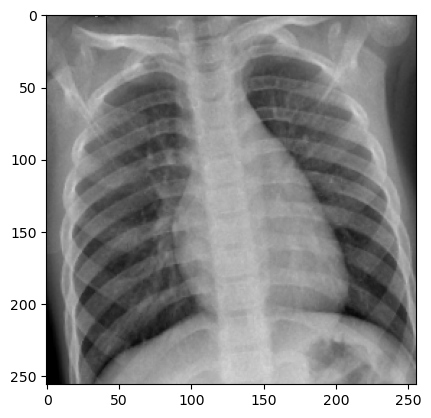

In [12]:
# Previewing sample image from training set
example_img = train_images[13]
plt.imshow(example_img)
print(train_labels[13])

From the image above, we can see this an example of a individual without pneumonia. 

1.0


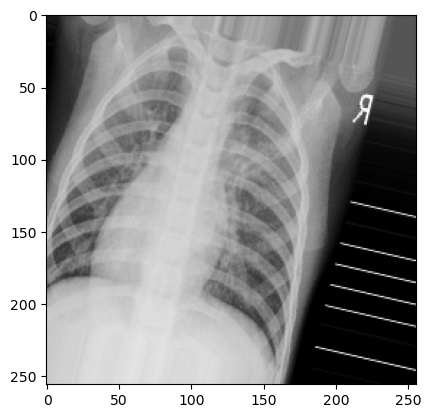

In [14]:
# Previewing sample image from training set
example_img_pne = train_images[10]
plt.imshow(example_img_pne)
print(train_labels[10])

From the image above, we can see this an example of a individual with pneumonia. 

### Class Distribution

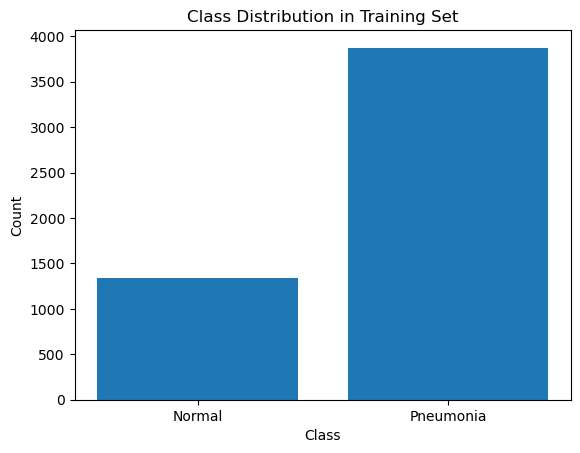

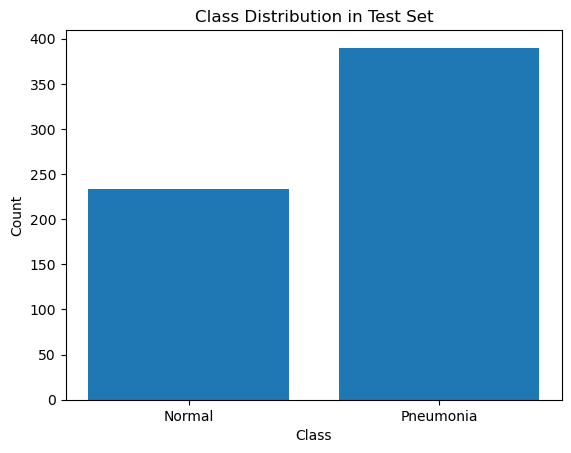

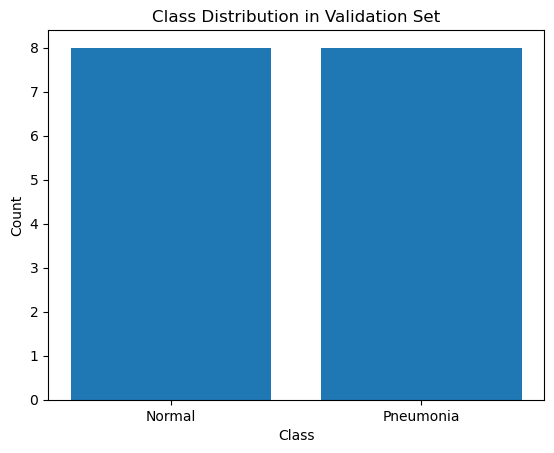

In [16]:
# Get class counts for each set
train_class_counts = np.unique(train_labels, return_counts=True)
test_class_counts = np.unique(test_labels, return_counts=True)
val_class_counts = np.unique(val_labels, return_counts=True)

# Define class labels
class_labels = {0: 'Normal', 1: 'Pneumonia'}

# Plot class distribution
def plot_class_distribution(class_counts, dataset):
    classes, counts = class_counts
    plt.bar(classes, counts)
    plt.title(f'Class Distribution in {dataset} Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(list(class_labels.keys()), [class_labels[c] for c in classes])  # Set x-axis ticks with labels
    plt.show()

# Plot for training set
plot_class_distribution(train_class_counts, 'Training')

# Plot for test set
plot_class_distribution(test_class_counts, 'Test')

# Plot for validation set
plot_class_distribution(val_class_counts, 'Validation')

Looking at the whole dataset, there is a total of 5856 images. As mentioned previously, the training set contains 5216 images, the validation set contains 16 images and the test set contains 624 images. 

- The training set has 3875 images labeled with pneumonia while having 1341 labeled as normal/without pneumonia. This image set seems to have an imbalanced class distribution since there are a long more images with pneumonia. This class imbalance could affect the model's performance and ability to generalize over the data. 
- The validation set has small number of images for both classes with 8 images labeled with pneumonia while having 8 labeled as normal/without pneumonia. 
- The test set has 390 images labeled with pneumonia while having 234 labeled as normal/without pneumonia. This image appears to have a more balanced distribution in comparison to the training set. Even though the the pneumonia images count is still higher than the images without pneumonia, the difference is not as vast as the training set. 

## Data Modeling 

To start, I'll be building a simple neural network model as the baseline model for pneumonia classficiation. Based on the results, I plan to adjust and iterate as needed to find the optimal best performing model. First I plan to test these models on a smaller subset of the training data for speed of runtimes. After the best model is determined, the whole dataset will be utilized. 

Metrics I will be looking at will include accuracy and recall of the model. 

In [17]:
# Set the seed for reproducibility
np.random.seed(42)

# Define the size of the subsample
subsample_size = 2500  

# Randomly select indices for the subsample
subsample_indices = np.random.choice(train_img.shape[0], subsample_size, replace=False)

# Create the subsampled training set
subsample_train_img = train_img[subsample_indices]
subsample_train_y = train_y[subsample_indices]

# Print the shape of the subsampled datasets
print(subsample_train_img.shape)
print(subsample_train_y.shape)

(2500, 196608)
(2500, 1)


### Baseline Model 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                2359308   
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2359421 (9.00 MB)
Trainable params: 2359421 (9.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 8s 119ms/step - loss: 1.1445 - accuracy: 0.7020 - recall: 0.9196 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_recall: 1.0000
Epoch 2/50
50/50 [==============================] - 4s 76ms/step - loss: 0.6783 - accuracy: 0.7412 - r

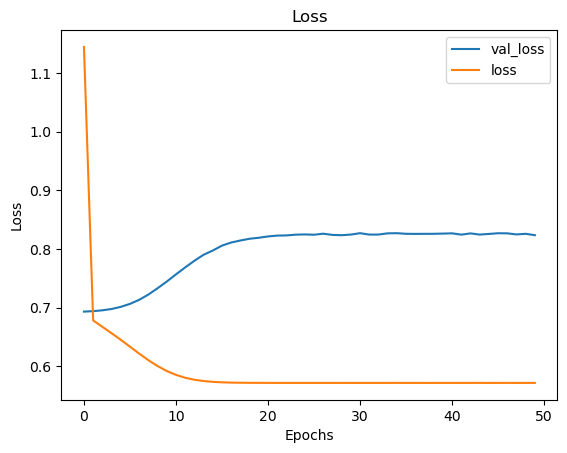

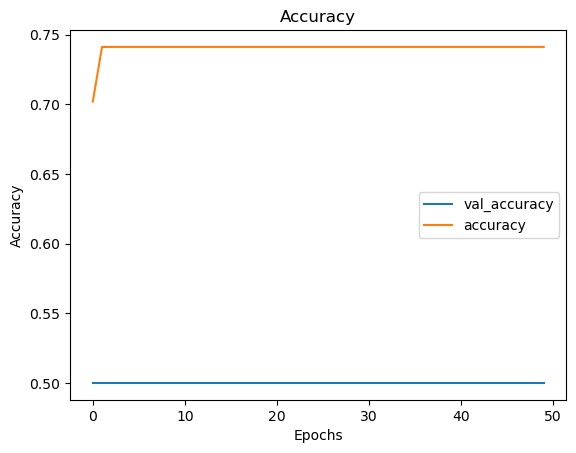

In [18]:
# Baseline model simple neural network
# Startign with 3 layers, 50 epochs and batch size of 50

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
model_1.summary()


# Fitting the model to the training data
results_1 = model_1.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y))

# Training Results 
results_train = model_1.evaluate(subsample_train_img, subsample_train_y)
# Test Results 
results_test = model_1.evaluate(test_img, test_y)

print('Train Results:', results_train)
print('Test Results:', results_test)


# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_1)

Looking at the baseline model:
- Train Accuracy: 0.7412
- Train Loss: 0.5718
- Test Accuracy: 0.6250
- Test Loss: 0.6931

Model performance was not the best as test accuracy was 0.625 and the model did show some signs of overfitting with train accuracy being higher. With both scores being lower will make adjustments to improve accuracy while moderating for overfitting. 

### Model 2

For model 2, an additional dense layer will be added to add more complexity to the model to see how it affects performance. 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                6291488   
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6292161 (24.00 MB)
Trainable params: 6292161 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 11s 183ms/step - loss: 1.4939 - accuracy: 0.6160 - val_loss: 0.6932 - val_accuracy: 0.5000
Epo

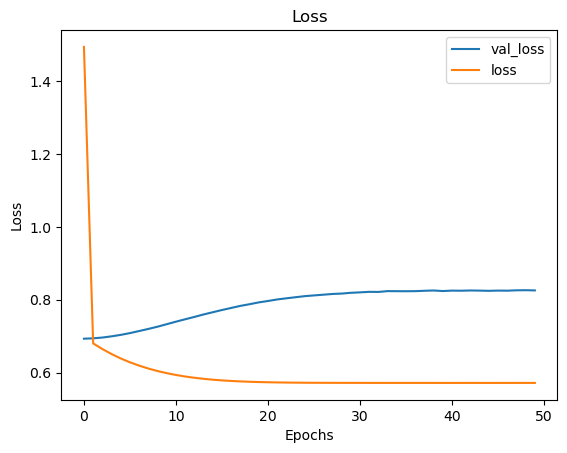

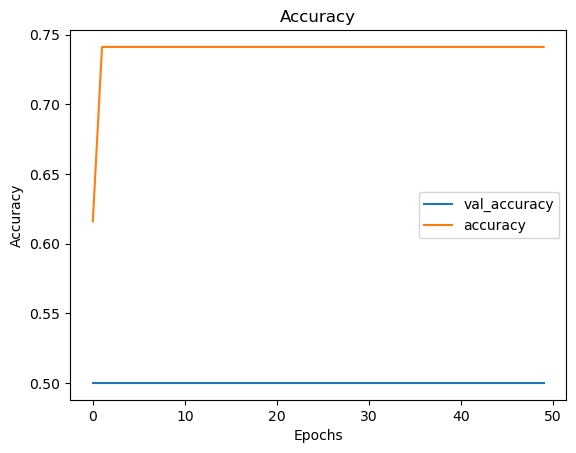

In [19]:
# Model 2 adding additional layer

model_2 = Sequential()
model_2.add(Dense(32, activation='relu', input_shape=(196608,)))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_2.summary()

# Fitting the model to the training data
results_2 = model_2.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y))

# Training Results 
results2_train = model_2.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results2_test = model_2.evaluate(test_img, test_y)

print('Train Results:', results2_train)
print('Test Results:', results2_test)

visualize_training_results(results_2)

Looking at the second model:
- Train Accuracy: 0.7412
- Train Loss: 0.5718
- Test Accuracy: 0.6250
- Test Loss: 0.6941

Model performance was virtually unchanged even with additional dense layer. 

## Model 3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                12582976  
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12585601 (48.01 MB)
Trainable params: 12585601 (48.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 16s 274ms/step - loss: 2.8436 - accuracy: 0.6520 - val_loss: 1.0106 - val_accuracy: 0.5000
E

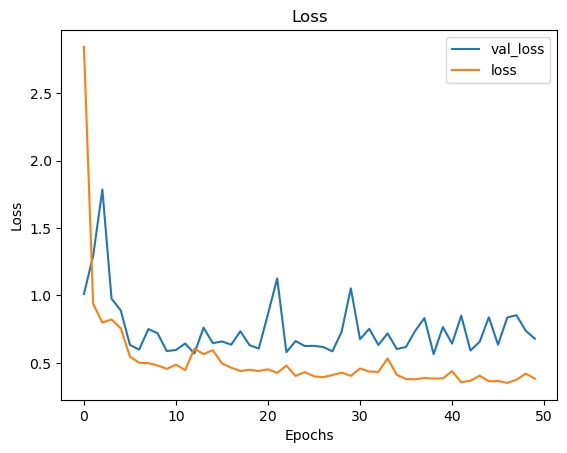

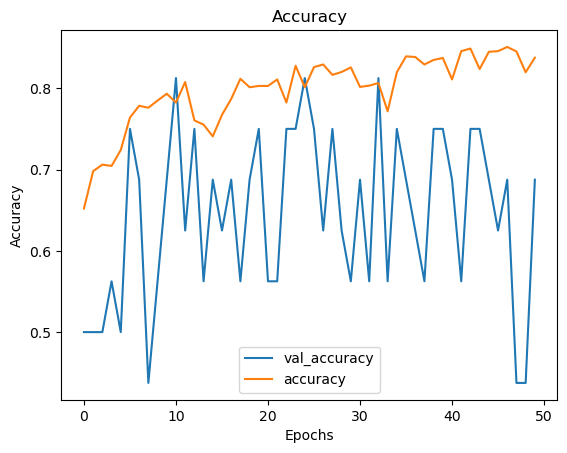

In [20]:
# Model 3 
# Adding more neurons per layer to deepen the network to capture more complex patterns

model_3 = Sequential()
model_3.add(Dense(64, activation='relu', input_shape=(196608,)))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_3.summary()

# Fitting the model to the training data
results_3 = model_3.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y))

# Training Results 
results3_train = model_3.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results3_test = model_3.evaluate(test_img, test_y)

print('Train Results:', results3_train)
print('Test Results:', results3_test)

# Viewing results 
visualize_training_results(results_3)

Looking at the third model:

- Train Accuracy: 0.8868
- Train Loss: 0.2838
- Test Accuracy: 0.7661
- Test Loss: 0.4865

Model performance improved greatly in both the test set and training with increasing the number of neurons per layer. Model does still show sugns of overfitting. Will continue to adjust and iterate to improve performance and reduce overfitting. 

### Model 4

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                12582976  
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12585601 (48.01 MB)
Trainable params: 12585601 (48.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 15s 263ms/step - loss: 0.7513 - accuracy: 0.7124 - recall: 0.9212 - val_loss: 0.7054 - val_a

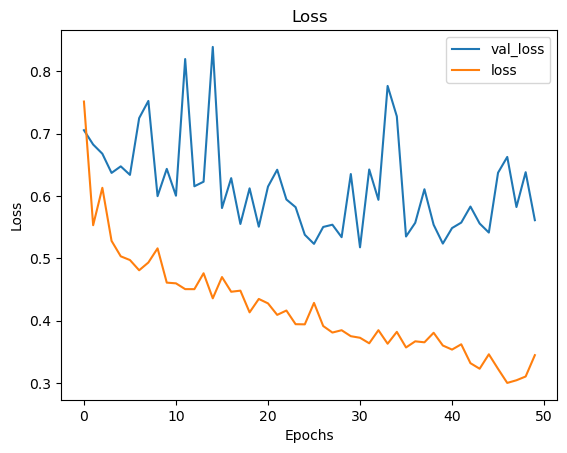

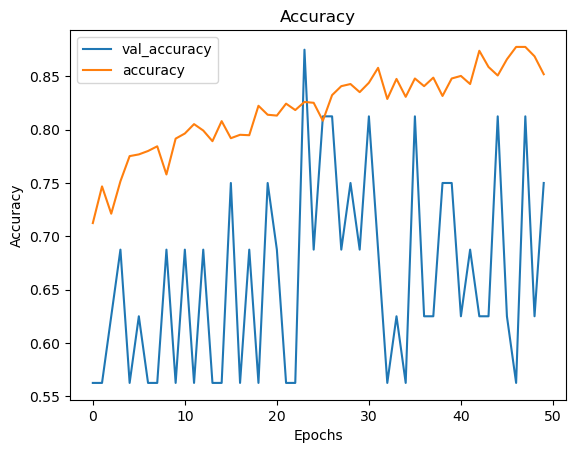

In [22]:
# Model 4
# Adjusting learning rate to see how this affects performance 
from tensorflow.keras import optimizers

model_4 = Sequential()
model_4.add(Dense(64, activation='relu', input_shape=(196608,)))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

# Building custom optimizer to adjust learning rate 
custom_optimizer = optimizers.Adam(learning_rate=0.0001)

# Compileing model 
model_4.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Inspecting model summary

model_4.summary()

# Fitting the model to the training data
results_4 = model_4.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y))

# Training Results 
results4_train = model_4.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results4_test = model_4.evaluate(test_img, test_y)

print('Train Results:', results4_train)
print('Test Results:', results4_test)

# Viewing results 
visualize_training_results(results_4)

Looking at the fourth model:

- Train Accuracy: 0.8144
- Train Loss: 0.4031
- Train Recall: 0.8235
- Test Accuracy: 0.7548
- Test Loss: 0.4971
- Test Recall: 0.7897

Model performance decreased slightly in both training and test sets, some overfitting was reduced between the train and test sets. 

### Model 5

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               25165952  
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dense_28 (Dense)            (None, 1)                 17        
                                                                 
Total params: 25176833 (96.04 MB)
Trainable params: 25176833 (96.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
5

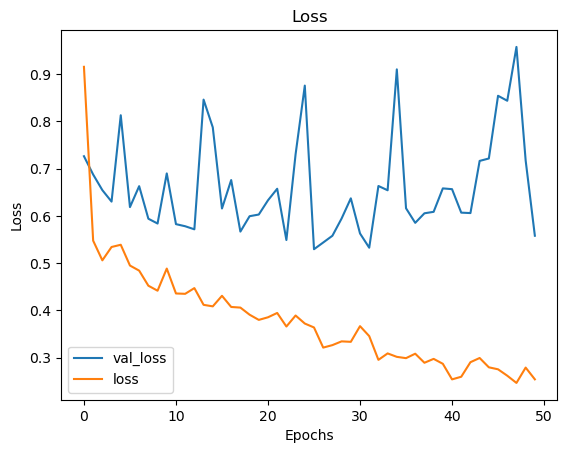

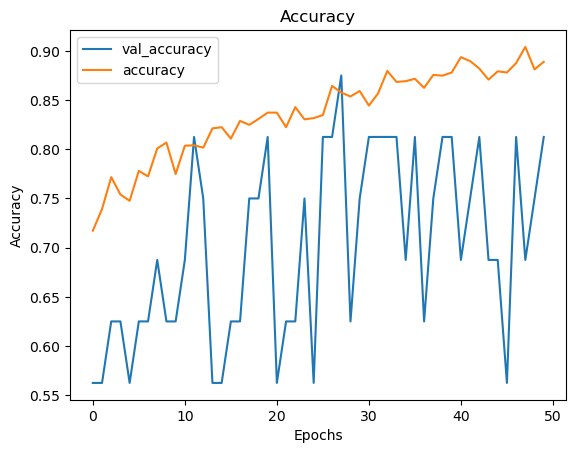

In [24]:
# Model 5
# adding additional layer to add complexity to see if performance improves 

model_5 = Sequential()
model_5.add(Dense(128, activation='relu', input_shape=(196608,)))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(16, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

# Building custom optimizer to adjust learning rate 
custom_optimizer = optimizers.Adam(learning_rate=0.0001)

# Compileing model 
model_5.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])


# Inspecting model summary

model_5.summary()

# Fitting the model to the training data
results_5 = model_5.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y), 
                        verbose=1)

# Training Results 
results5_train = model_5.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results5_test = model_5.evaluate(test_img, test_y)

print('Train Results:', results5_train)
print('Test Results:', results5_test)

# Viewing results 
visualize_training_results(results_5)

Looking at the fifth model:

- Train Accuracy: 0.9172
- Train Loss: 0.2087
- Train Recall: 0.9655
- Test Accuracy: 0.7837
- Test Loss: 0.4993
- Test Recall: 0.9282

Model performance increased in both the training and test sets while recall score greatly improved in each as well. There did seem to be an increase in the model overfitting. Will iterate and work to reduce. 

### Model 6

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 128)               25165952  
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 16)                528       
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
                                                                 
Total params: 25176833 (96.04 MB)
Trainable params: 25176833 (96.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
5

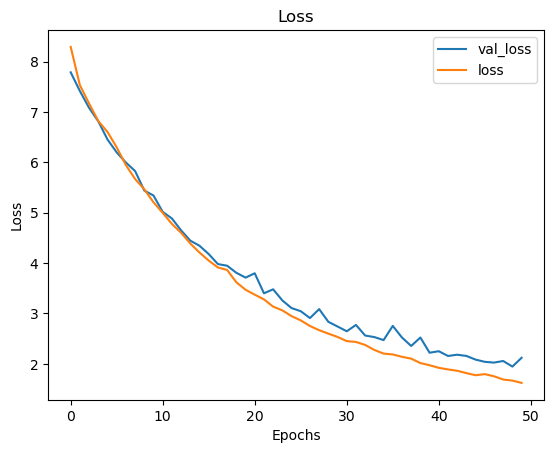

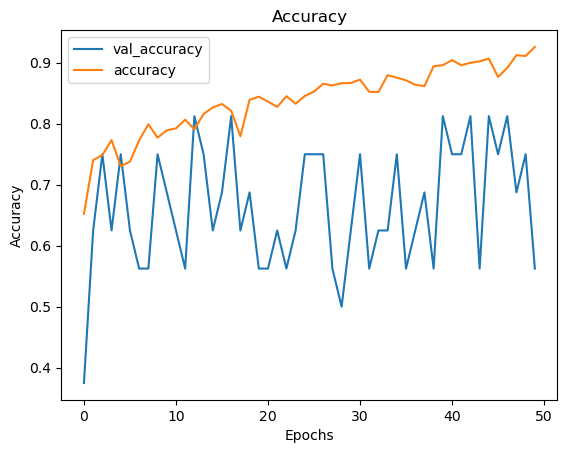

In [25]:
# Model 6
# adding L2 Regularization to dense layers to reduce overfitting

model_6 = Sequential()
model_6.add(Dense(128, activation='relu', input_shape=(196608,)))
model_6.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
model_6.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_6.add(Dense(1, activation='sigmoid'))

# Building custom optimizer to adjust learning rate 
custom_optimizer = optimizers.Adam(learning_rate=0.0001)

# Compiling model 
model_6.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])


# Inspecting model summary

model_6.summary()

# Fitting the model to the training data
results_6 = model_6.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y), 
                        verbose=1)

# Training Results 
results6_train = model_6.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results6_test = model_6.evaluate(test_img, test_y)

print('Train Results:', results6_train)
print('Test Results:', results6_test)

# Viewing results 
visualize_training_results(results_6)

Looking at the sixth model:

- Train Accuracy: 0.9268
- Train Loss: 1.167
- Train Recall: 0.9228
- Test Accuracy: 0.8109
- Test Loss: 1.8514
- Test Recall: 0.8077

Model performance increased in both the training and test sets while recall score actually decreased in both sets

### Model 7

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 128)               25165952  
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 1)                 17        
                                                                 
Total params: 25176833 (96.04 MB)
Trainable params: 25176833 (96.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
5

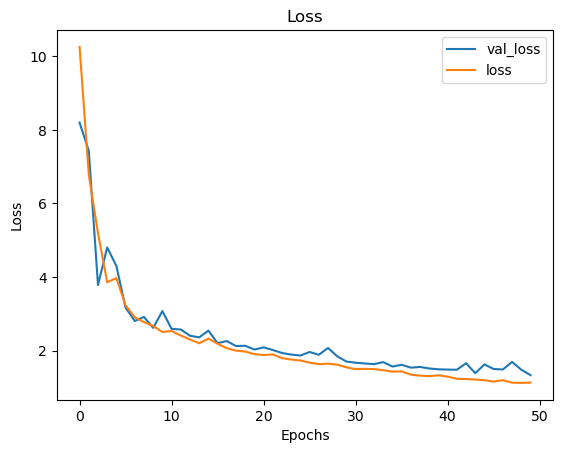

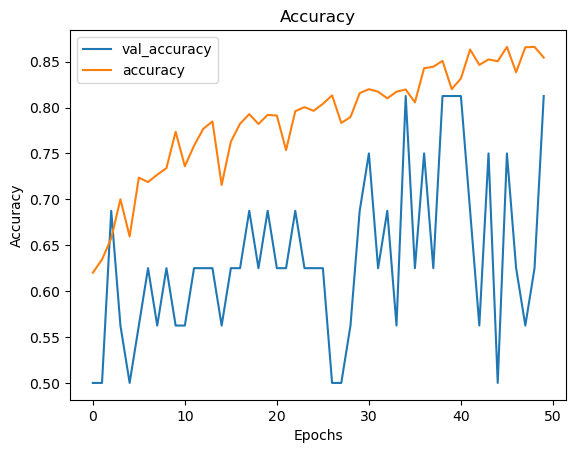

In [26]:
# Model 7
# Adjusting learning rate from previous model 
# Learning rate will be 0.001

model_7 = Sequential()
model_7.add(Dense(128, activation='relu', input_shape=(196608,)))
model_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_7.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
model_7.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_7.add(Dense(1, activation='sigmoid'))

# Building custom optimizer to adjust learning rate 
custom_optimizer = optimizers.Adam(learning_rate=0.001)

# Compiling model 
model_7.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])


# Inspecting model summary

model_7.summary()

# Fitting the model to the training data
results_7 = model_7.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y), 
                        verbose=1)

# Training Results 
results7_train = model_7.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results7_test = model_7.evaluate(test_img, test_y)

print('Train Results:', results7_train)
print('Test Results:', results7_test)

# Viewing results 
visualize_training_results(results_7)

Looking at the seventh model:

- Train Accuracy: 0.8756
- Train Loss: 1.0764
- Train Recall: 0.9790
- Test Accuracy: 0.7468
- Test Loss: 1.2820
- Test Recall: 0.8846

Model performance decreased in both the training and test sets while recall score actually improved in both sets.

### Model 7 

Model 7 ran again with higher learning rate. 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 128)               25165952  
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 32)                2080      
                                                                 
 dense_42 (Dense)            (None, 16)                528       
                                                                 
 dense_43 (Dense)            (None, 1)                 17        
                                                                 
Total params: 25176833 (96.04 MB)
Trainable params: 25176833 (96.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
5

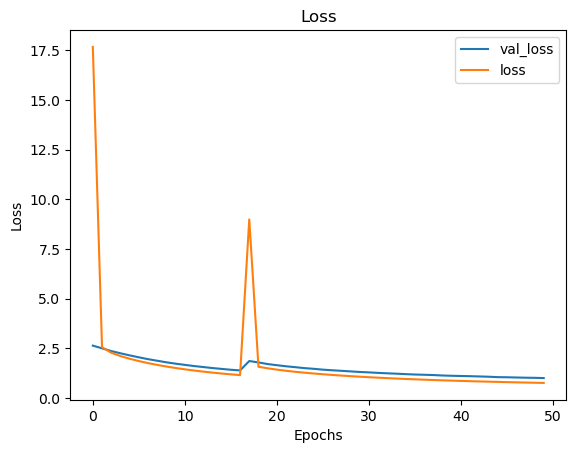

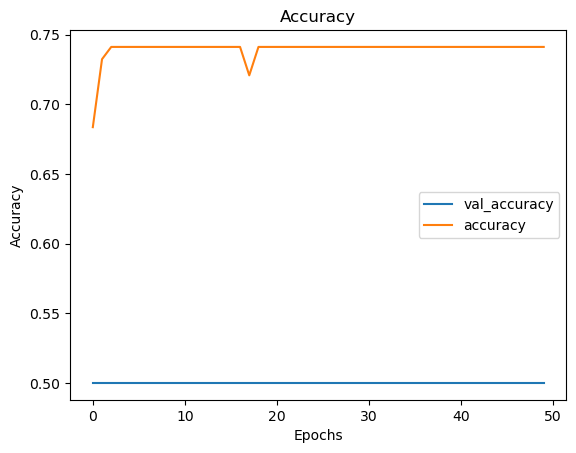

In [27]:
# Model 7
# Adjusting learning rate from previous model 
# Learning rate will be 0.01

model_7 = Sequential()
model_7.add(Dense(128, activation='relu', input_shape=(196608,)))
model_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_7.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
model_7.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_7.add(Dense(1, activation='sigmoid'))

# Building custom optimizer to adjust learning rate 
custom_optimizer = optimizers.Adam(learning_rate=0.01)

# Compiling model 
model_7.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])


# Inspecting model summary

model_7.summary()

# Fitting the model to the training data
results_7 = model_7.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=50, 
                        validation_data=(val_img, val_y), 
                        verbose=1)

# Training Results 
results7_train = model_7.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results7_test = model_7.evaluate(test_img, test_y)

print('Train Results:', results7_train)
print('Test Results:', results7_test)

# Viewing results 
visualize_training_results(results_7)

### Model 8

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 128)               25165952  
                                                                 
 dense_50 (Dense)            (None, 64)                8256      
                                                                 
 dense_51 (Dense)            (None, 32)                2080      
                                                                 
 dense_52 (Dense)            (None, 16)                528       
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 25176833 (96.04 MB)
Trainable params: 25176833 (96.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


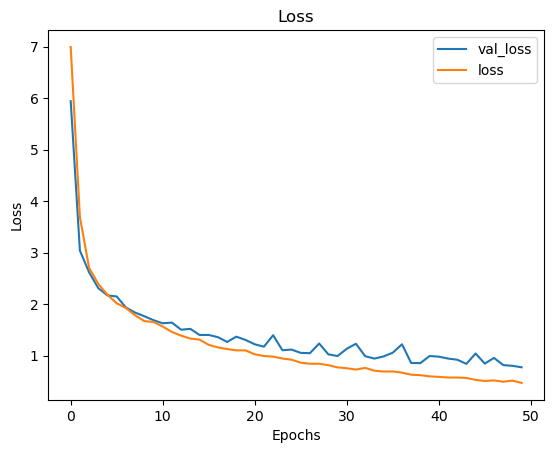

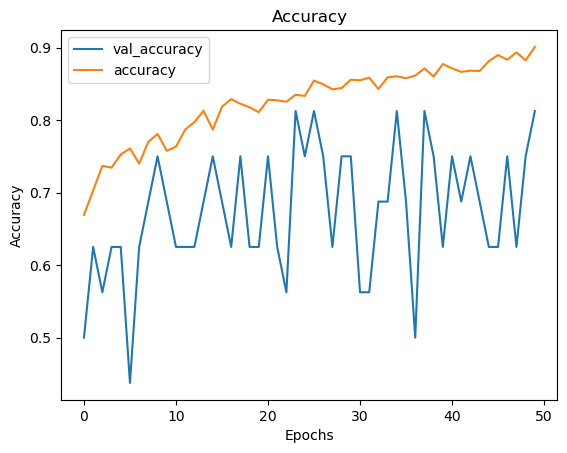

In [29]:
# Model 8
# Adjusting batch size to 32 instead of 50
# Learning rate will remain the same at 0.001

model_8 = Sequential()
model_8.add(Dense(128, activation='relu', input_shape=(196608,)))
model_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_8.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
model_8.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_8.add(Dense(1, activation='sigmoid'))

# Building custom optimizer to adjust learning rate 
custom_optimizer = optimizers.Adam(learning_rate=0.001)

# Compiling model 
model_8.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])


# Inspecting model summary

model_8.summary()

# Fitting the model to the training data
results_8 = model_8.fit(subsample_train_img, subsample_train_y, 
                        epochs=50, 
                        batch_size=32, 
                        validation_data=(val_img, val_y), 
                        verbose=1)

# Training Results 
results8_train = model_8.evaluate(subsample_train_img, subsample_train_y)

# Test Results 
results8_test = model_8.evaluate(test_img, test_y)

print('Train Results:', results8_train)
print('Test Results:', results8_test)

# Viewing results 
visualize_training_results(results_8)

## Building a Convolutional Neural Network Model

I previously started with and built a regular neural network model to classify pneumonia based on Chest X-ray images. For comparison I plan to build a Convolution Neural Network Model (CNN) to see if this model performs better. 


In [30]:
# Set the seed for reproducibility
np.random.seed(42)

# Define the size of the subsample
subsample_size = 2500  

# Randomly select indices for the subsample
subsample_indices = np.random.choice(train_images.shape[0], subsample_size, replace=False)

# Create the subsampled training set
cnn_subsample_train_img = train_images[subsample_indices]
cnn_subsample_train_y = train_labels[subsample_indices]

# Print the shape of the subsampled datasets
print(cnn_subsample_train_img.shape)
print(cnn_subsample_train_y.shape)

(2500, 256, 256, 3)
(2500,)


In [47]:
# Define a function to plot training and validation curves
def plot_curves(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Define a function to get evaluation metrics
def get_evaluation_metrics(model):

    # Evaluate the model 
    test_evaluation_results = model.evaluate(test_images, test_labels)
    train_evaluation_results = model.evaluate(cnn_subsample_train_img, cnn_subsample_train_y)

    # Print all evaluation results
    print("Test Evaluation Results:", test_evaluation_results)
    print("Train Evaluation Results:", train_evaluation_results)

    # Access specific values
    test_loss = test_evaluation_results[0]
    test_acc = test_evaluation_results[1]
    test_recall = test_evaluation_results[2]
    train_loss = train_evaluation_results[0]
    train_acc = train_evaluation_results[1]
    train_recall = train_evaluation_results[2]


    # Print specific values
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
    print("Test Recall:", test_recall)
    print("Train Loss:", train_loss)
    print("Train Accuracy:", train_acc)
    print("Train Recall:", train_recall)

### Baseline CNN

In [31]:
# cnn baseline model

cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters= 8, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(16, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
cnn_model.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model.summary()

# Fit and train the model 
cnn_results_1= cnn_model.fit(cnn_subsample_train_img, cnn_subsample_train_y, epochs=10, batch_size=128)

# Evaluate the model 
test_acc = cnn_model.evaluate(test_images, test_labels)
print(test_acc)

# Viewing Results 
visualize_training_results(cnn_results_1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 57600)           

ValueError: too many values to unpack (expected 2)

In [48]:
get_evaluation_metrics(cnn_model)



79/79 [==============================] - 38s 469ms/step - loss: 0.3280 - accuracy: 0.8360 - recall: 0.9671
Test Evaluation Results: [0.6669780015945435, 0.7275640964508057, 0.9769230484962463]
Train Evaluation Results: [0.3280021846294403, 0.8360000252723694, 0.9670804142951965]
Test Loss: 0.6669780015945435
Test Accuracy: 0.7275640964508057
Test Recall: 0.9769230484962463
Train Loss: 0.3280021846294403
Train Accuracy: 0.8360000252723694
Train Recall: 0.9670804142951965


### CNN Model 2

In [35]:
# cnn model #2
# increases number of filters to add complexity, only increased the conv2d layers

cnn_model_2= models.Sequential()
cnn_model_2.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(16, activation='relu'))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
cnn_model_2.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model_2.summary()

# Fit and train the model 
cnn_results_2= cnn_model_2.fit(cnn_subsample_train_img, cnn_subsample_train_y, epochs=10, batch_size=128)

history = cnn_results_2


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 flatten_2 (Flatten)         (None, 115200)          

In [43]:
# Evaluate the model
test_evaluation_results = cnn_model_2.evaluate(test_images, test_labels)
train_evaluation_results = cnn_model_2.evaluate(cnn_subsample_train_img, cnn_subsample_train_y)

# Print all evaluation results
print("Test Evaluation Results:", test_evaluation_results)
print("Train Evaluation Results:", train_evaluation_results)

# Access specific values
test_loss = test_evaluation_results[0]
test_acc = test_evaluation_results[1]
test_recall = test_evaluation_results[2]
train_loss = train_evaluation_results[0]
train_acc = train_evaluation_results[1]
train_recall = train_evaluation_results[2]


# Print specific values
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Recall:", test_recall)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_acc)
print("Train Recall:", train_recall)


79/79 [==============================] - 43s 537ms/step - loss: 0.1383 - accuracy: 0.9460 - recall: 0.9504
Test Evaluation Results: [0.5631915330886841, 0.8333333134651184, 0.9179487228393555]
Train Evaluation Results: [0.13834646344184875, 0.9459999799728394, 0.9503507614135742]
Test Loss: 0.5631915330886841
Test Accuracy: 0.8333333134651184
Train Loss: 0.13834646344184875
Train Accuracy: 0.9459999799728394


Looking at the second cnn model:

- Train Accuracy: 0.9460
- Train Loss: 0.1383
- Train Recall: 0.9504
- Test Accuracy: 0.8333
- Test Loss:0.5632
- Test Recall: 0.9179

Overall the model performance improved from the baseline model. The model performed well on recall with both the training and the test sets. The model did have a higher accuracy on the training set indicating that the model is overfitting. Will continue iterating over model to see if performance can be improved. 

### Model 2 with adjusted learning rate 

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_8 (Flatten)         (None, 115200)          

KeyError: 'val_accuracy'

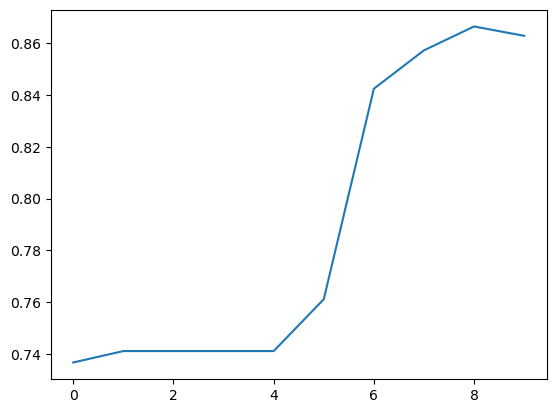

In [55]:
# Adjusting learning rate for model 2

cnn_model_2= models.Sequential()
cnn_model_2.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(16, activation='relu'))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.0001)
cnn_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model_2.summary()

# Fit and train the model 
cnn_results_2= cnn_model_2.fit(cnn_subsample_train_img, cnn_subsample_train_y, epochs=10, batch_size=128)

history2= cnn_results_2

# Evaluate the model 
get_evaluation_metrics(cnn_model_2)

# Plot the curves
plot_curves(history2)

### Model 2 with adjusted learning rate and increased number of layers 

In [56]:
# Adjusting learning rate for model 2
# two additional conv2d layer and two additional pooling layer

cnn_model_2= models.Sequential()
cnn_model_2.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
# Adding dense layers on top

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(16, activation='relu'))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.0001)
cnn_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model_2.summary()

# Fit and train the model 
cnn_results_2= cnn_model_2.fit(cnn_subsample_train_img, cnn_subsample_train_y, epochs=10, batch_size=128)

history = cnn_results_2

# Evaluate the model 
get_evaluation_metrics(cnn_model_2)

# Plot the curves
#plot_curves(history2)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 30, 32)      

### CNN Model 2 with adjusted learning rate, increased layers and increase epochs

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 30, 30, 32)      

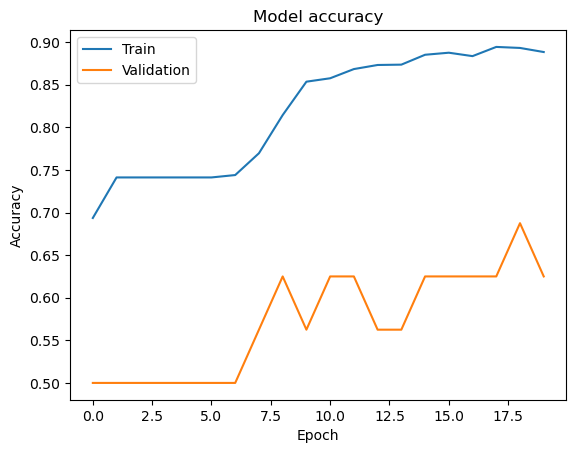

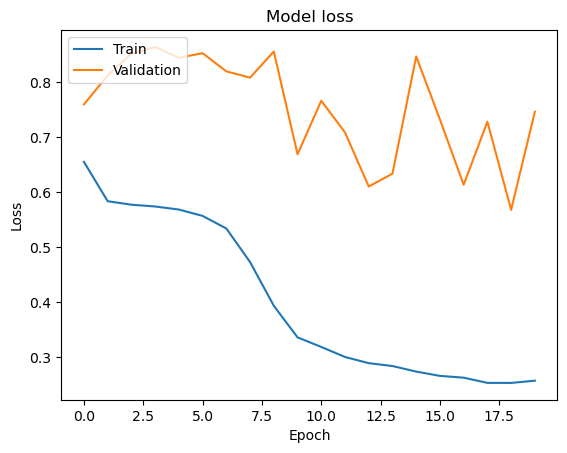

In [59]:
# Adjusting learning rate for model 2
# two additional conv2d layer and two additional pooling layer
# Epcochs changed to 20

cnn_model_2= models.Sequential()
cnn_model_2.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
# Adding dense layers on top

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(16, activation='relu'))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.0001)
cnn_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model_2.summary()

# Fit and train the model 
history = cnn_results_2= cnn_model_2.fit(cnn_subsample_train_img, cnn_subsample_train_y, 
                               epochs=20, 
                               batch_size=128, 
                               validation_data=(val_images, val_labels))


# Evaluate the model 
get_evaluation_metrics(cnn_model_2)

# Plot the curves
plot_curves(history)

### CNN Model 2 Adding batch normalization from previous model

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_15 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_16 (Ba  (None, 125, 125, 32)      128       
 tchNormalization)                                               
                                                     

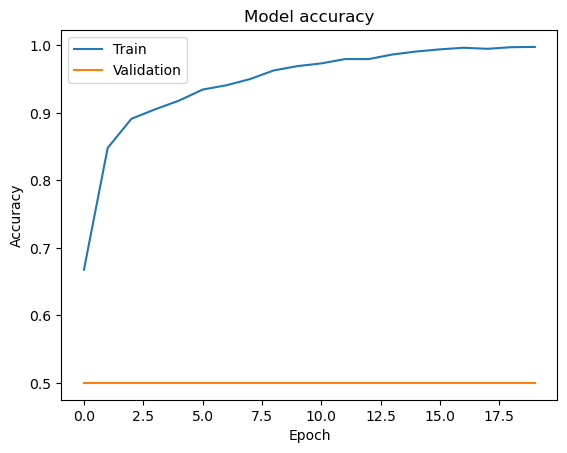

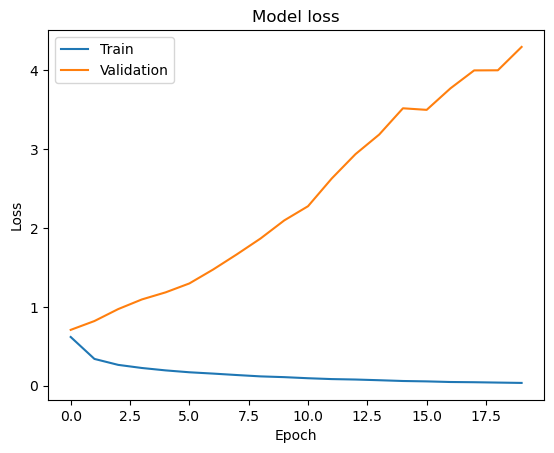

In [60]:
# Adjusting learning rate for model 2
# two additional conv2d layer and two additional pooling layer
# Epcochs changed to 20
# Batch normalization added after each convolutional layer
# Adjust BatchNormalization parameters

cnn_model_2= models.Sequential()
cnn_model_2.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))

cnn_model_2.add(layers.BatchNormalization()
cnn_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.BatchNormalization()
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.BatchNormalization()
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.BatchNormalization()
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.BatchNormalization()
# Adding dense layers on top

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(16, activation='relu'))
cnn_model_2.add(layers.BatchNormalization()
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.0001)
cnn_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model_2.summary()

# Fit and train the model 
history = cnn_results_2= cnn_model_2.fit(cnn_subsample_train_img, cnn_subsample_train_y, 
                               epochs=20, 
                               batch_size=128, 
                               validation_data=(val_images, val_labels))


# Evaluate the model 
get_evaluation_metrics(cnn_model_2)

# Plot the curves
plot_curves(history)

### CNN Model 2 adjusted batch normalization parameters

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_20 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_21 (Ba  (None, 125, 125, 32)      128       
 tchNormalization)                                               
                                                     

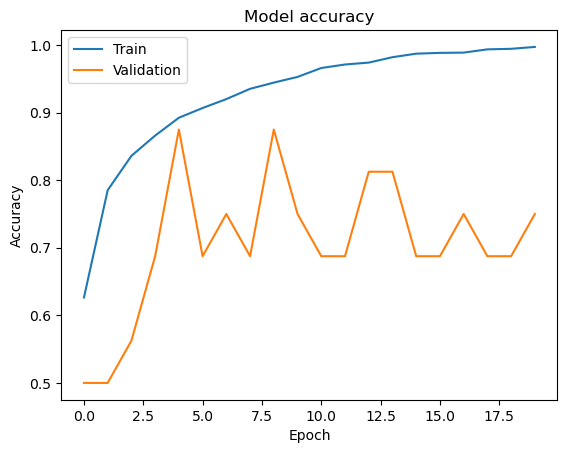

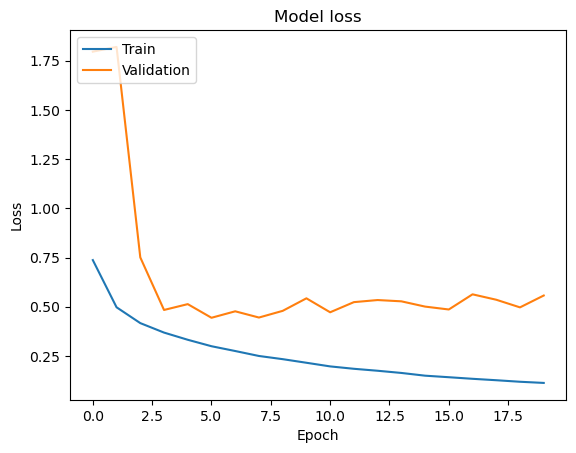

In [61]:
# Adjusting learning rate for model 2
# two additional conv2d layer and two additional pooling layer
# Epcochs changed to 20
# Batch normalization added after each convolutional layer
# Adjust BatchNormalization parameters

cnn_model_2= models.Sequential()
cnn_model_2.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))

cnn_model_2.add(layers.BatchNormalization(momentum=0.9, epsilon=1e-5))
cnn_model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.BatchNormalization(momentum=0.9, epsilon=1e-5))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.BatchNormalization(momentum=0.9, epsilon=1e-5))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.BatchNormalization(momentum=0.9, epsilon=1e-5))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))
cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_2.add(layers.BatchNormalization(momentum=0.9, epsilon=1e-5))
# Adding dense layers on top

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(16, activation='relu'))
cnn_model_2.add(layers.BatchNormalization(momentum=0.9, epsilon=1e-5))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.0001)
cnn_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model_2.summary()

# Fit and train the model 
history = cnn_results_2= cnn_model_2.fit(cnn_subsample_train_img, cnn_subsample_train_y, 
                               epochs=20, 
                               batch_size=128, 
                               validation_data=(val_images, val_labels))


# Evaluate the model 
get_evaluation_metrics(cnn_model_2)

# Plot the curves
plot_curves(history)

### CNN Model 3

In [51]:
# cnn model 3
# adding batch normalization to see if this improves performance and reduces overfitting 

cnn_model3 = models.Sequential()
cnn_model3.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 3)))
cnn_model3.add(layers.BatchNormalization())
cnn_model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model3.add(layers.BatchNormalization())
cnn_model3.add(layers.MaxPooling2D((2, 2)))
cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model3.add(layers.BatchNormalization())


# Adding dense layers on top

cnn_model3.add(layers.Flatten())
cnn_model3.add(layers.Dense(16, activation='relu'))
cnn_model3.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
cnn_model3.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model3.summary()

# Train the model and store the history
history = cnn_model3.fit(cnn_subsample_train_img, cnn_subsample_train_y, 
                         epochs=10, 
                         batch_size=128, 
                         validation_data=(val_images, val_labels))

# Evaluate the model 
get_evaluation_metrics(cnn_model3)

# Plot the curves
#plot_curves(history)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 254, 254, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_7 (Bat  (None, 125, 125, 32)      128       
 chNormalization)                                                
                                                     

### CNN Model 4

In [53]:
# CNN model 4
# Adjusting learning rate from previous model 3

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 3)))
cnn_model4.add(layers.BatchNormalization())
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.BatchNormalization())
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.BatchNormalization())


# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu'))
cnn_model4.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.0001)
cnn_model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Train the model and store the history
history4 = cnn_model4.fit(cnn_subsample_train_img, cnn_subsample_train_y, 
                          epochs=10, 
                          batch_size=128,
                          validation_data=(val_images, val_labels))

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Plot the curves
#plot_curves(history4)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_12 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_13 (Ba  (None, 125, 125, 32)      128       
 tchNormalization)                                               
                                                     

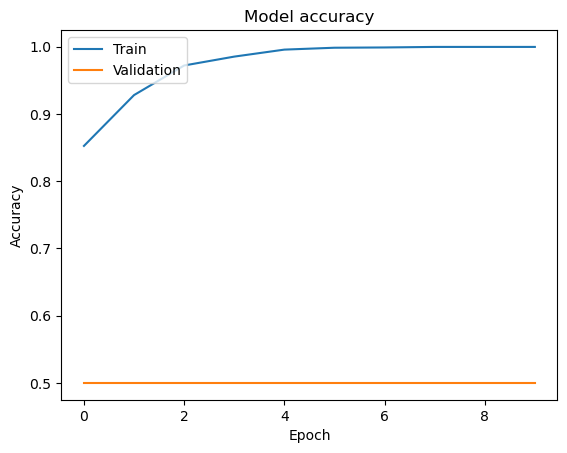

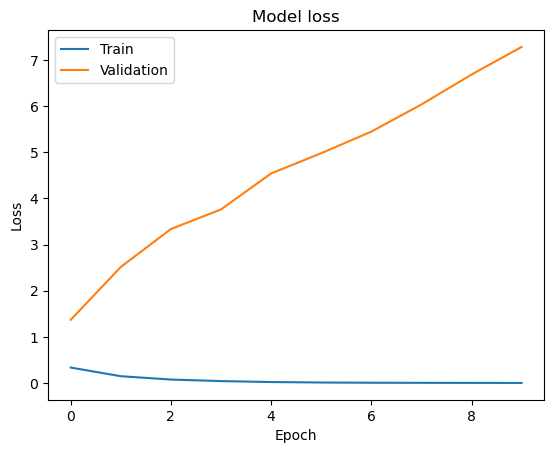

In [54]:
# Plot the curves
plot_curves(history4)

## Evaluation 

## Conclusion and Recommendations 

## Limitations and Future Considerations